Reading classics [Deep Learning Models](https://nbviewer.jupyter.org/github/rasbt/deeplearning-models/blob/master/pytorch_ipynb/cnn/cnn-alexnet-cifar10.ipynb)

## Code Modules, Classes & Functions

In [1]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch
from tensorflow import image as timage
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn as tnn
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" if torch.cuda.is_available() 
                 else "cpu")

In [2]:
class TData(tds):
    def __init__(self,X,y):   
        self.X=torch.tensor(X,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        train_img,train_lbl=self.X[index],self.y[index]
        return train_img,train_lbl
    def __len__(self):
        return self.y.shape[0]

In [3]:
class AlexNN(tnn.Module):
    def __init__(self,num_classes):
        super(AlexNN,self).__init__()
        self.features=tnn.Sequential(
            tnn.Conv2d(3,64,kernel_size=11,
                       stride=4,padding=2),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(kernel_size=3,stride=2),
            tnn.Conv2d(64,192,kernel_size=5,padding=2),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(kernel_size=3,stride=2),
            tnn.Conv2d(192,384,kernel_size=3,padding=1),
            tnn.ReLU(inplace=True),
            tnn.Conv2d(384,256,kernel_size=3,padding=1),
            tnn.ReLU(inplace=True),
            tnn.Conv2d(256,256,kernel_size=3,padding=1),
            tnn.ReLU(inplace=True),
            tnn.MaxPool2d(kernel_size=3,stride=2))
        self.avgpool=tnn.AdaptiveAvgPool2d((6,6))
        self.classifier=tnn.Sequential(
            tnn.Dropout(.5),
            tnn.Linear(256*6*6,4096),
            tnn.ReLU(inplace=True),
            tnn.Dropout(.5),
            tnn.Linear(4096,4096),
            tnn.ReLU(inplace=True),
            tnn.Linear(4096,num_classes))
    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        x=x.view(x.size(0),256*6*6)
        logits=self.classifier(x)
        probs=tnn.functional.softmax(logits,dim=1)
        return logits,probs

In [4]:
def model_acc(model,data_loader):
    correct_preds,num_examples=0,0    
    for features,targets in data_loader:
        features=features.to(dev)
        targets=targets.to(dev)
        logits,probs=model(features)
        _,pred_labels=torch.max(probs,1)
        num_examples+=targets.size(0)
        correct_preds+=(pred_labels==targets).sum()        
    return correct_preds.float()/num_examples*100

In [5]:
def display_examples(data_loader):
    for images,labels in data_loader:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(11,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(64,64,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
def show_examples(train_loader,classes,num_examples):
    dataiter=iter(train_loader)
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:num_examples]))
    print('^'.join('%9s'%classes[labels[j]] 
                   for j in range(num_examples)),end='^')

In [6]:
@register_line_magic
def train_run(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets)
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%200:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train)//batch_size,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader),
                   model_acc(model,valid_loader)))
@register_line_magic
def train_run2(epochs):
    epochs=int(epochs)
    for epoch in range(epochs):
        model.train()
        for batch_ids,(features,targets) in enumerate(train_loader2):        
            features=features.to(dev); targets=targets.to(dev)
            logits,probs=model(features)
            cost=tnn.functional.cross_entropy(logits,targets.long())
            optimizer.zero_grad(); cost.backward()
            optimizer.step()
            if not batch_ids%50:
                print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                       %(epoch+1,epochs,batch_ids, 
                         len(train2)//batch_size2,cost))
        model.eval()         
        with torch.set_grad_enabled(False):
            print('Epoch: %03d/%03d train acc: %.2f%% valid acc: %.2f%%'%\
                  (epoch+1,epochs,
                   model_acc(model,train_loader2),
                   model_acc(model,valid_loader2)))
@register_line_magic
def print_acc(n):
    if int(n)==1:
        data_loader=\
        [train_loader,valid_loader,test_loader]
    if int(n)==2:
        data_loader=\
        [train_loader2,valid_loader2,test_loader2]
    print('Train accuracy: %.4f%%'%\
    (model_acc(model,data_loader[0])))
    print('Valid accuracy: %.4f%%'%\
    (model_acc(model,data_loader[1])))
    print('Test accuracy: %.4f%%'%\
    (model_acc(model,data_loader[2])))

## Data

In [7]:
random_seed=1; batch_size=128
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
train_transform=transforms\
.Compose([transforms.Resize((70,70)),
          transforms.RandomCrop((64,64)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.Resize((70,70)),
          transforms.CenterCrop((64,64)),
          transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
train_loader=tdl(dataset=train,shuffle=True, 
                 batch_size=batch_size)
valid_loader=tdl(dataset=valid,shuffle=True, 
                 batch_size=batch_size)
test_loader=tdl(dataset=test,shuffle=False, 
                batch_size=batch_size)

Extracting data/cifar-10-python.tar.gz to data


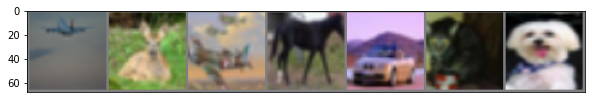

    plane^     deer^    plane^    horse^      car^      cat^      dog^

In [8]:
classes=('plane','car','bird','cat','deer',
         'dog','frog','horse','ship','truck')
show_examples(valid_loader,classes,7)

In [9]:
fpath='../input/classification-of-handwritten-letters/'
f='LetterColorImages_123.h5'
f=h5py.File(fpath+f,'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')/255
x=np.array(timage.resize(x,[64,64]))\
.reshape(-1,3,64,64)
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]
x_valid.shape,y_valid.shape

['backgrounds', 'images', 'labels']


((1419, 3, 64, 64), (1419,))

Image dimensions: torch.Size([128, 3, 64, 64])
Label dimensions: torch.Size([128])


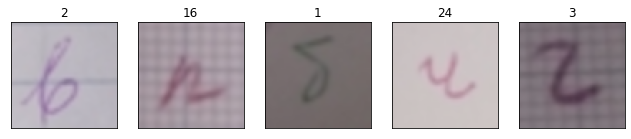

In [10]:
random_seed=1; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
train_loader2=tdl(dataset=train2,
                  batch_size=batch_size2,shuffle=True)
valid_loader2=tdl(dataset=valid2,
                  batch_size=batch_size2,shuffle=True)
test_loader2=tdl(dataset=test2,
                 batch_size=batch_size2,shuffle=False)
display_examples(valid_loader2)

## AlexNet Training

In [11]:
torch.manual_seed(random_seed)
num_classes=10; learning_rate=.0001
model=AlexNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate)

In [12]:
%train_run 10

Epoch: 001/010 | Batch 000/343 | Cost: 2.3028
Epoch: 001/010 | Batch 200/343 | Cost: 1.5471
Epoch: 001/010 train acc: 41.36% valid acc: 40.78%
Epoch: 002/010 | Batch 000/343 | Cost: 1.6713
Epoch: 002/010 | Batch 200/343 | Cost: 1.4370
Epoch: 002/010 train acc: 50.92% valid acc: 51.17%
Epoch: 003/010 | Batch 000/343 | Cost: 1.2911
Epoch: 003/010 | Batch 200/343 | Cost: 1.0617
Epoch: 003/010 train acc: 60.55% valid acc: 60.45%
Epoch: 004/010 | Batch 000/343 | Cost: 1.0571
Epoch: 004/010 | Batch 200/343 | Cost: 1.1223
Epoch: 004/010 train acc: 66.17% valid acc: 63.87%
Epoch: 005/010 | Batch 000/343 | Cost: 0.7744
Epoch: 005/010 | Batch 200/343 | Cost: 0.9316
Epoch: 005/010 train acc: 69.89% valid acc: 66.63%
Epoch: 006/010 | Batch 000/343 | Cost: 0.8511
Epoch: 006/010 | Batch 200/343 | Cost: 0.7265
Epoch: 006/010 train acc: 72.53% valid acc: 68.28%
Epoch: 007/010 | Batch 000/343 | Cost: 0.8516
Epoch: 007/010 | Batch 200/343 | Cost: 0.7178
Epoch: 007/010 train acc: 71.35% valid acc: 66.02%

In [13]:
%print_acc 1

Train accuracy: 80.2091%
Valid accuracy: 71.2167%
Test accuracy: 71.2900%


In [14]:
torch.manual_seed(random_seed)
num_classes=33; learning_rate=.0001
model=AlexNN(num_classes)
model.to(dev)
optimizer=torch.optim.Adam(model.parameters(),
                           lr=learning_rate) 

In [15]:
%train_run2 30

Epoch: 001/030 | Batch 000/088 | Cost: 3.4962
Epoch: 001/030 | Batch 050/088 | Cost: 3.5042
Epoch: 001/030 train acc: 3.83% valid acc: 4.23%
Epoch: 002/030 | Batch 000/088 | Cost: 3.4586
Epoch: 002/030 | Batch 050/088 | Cost: 3.4302
Epoch: 002/030 train acc: 4.92% valid acc: 4.58%
Epoch: 003/030 | Batch 000/088 | Cost: 3.3900
Epoch: 003/030 | Batch 050/088 | Cost: 3.3879
Epoch: 003/030 train acc: 5.46% valid acc: 5.00%
Epoch: 004/030 | Batch 000/088 | Cost: 3.4042
Epoch: 004/030 | Batch 050/088 | Cost: 3.3362
Epoch: 004/030 train acc: 4.99% valid acc: 5.07%
Epoch: 005/030 | Batch 000/088 | Cost: 3.3495
Epoch: 005/030 | Batch 050/088 | Cost: 3.3904
Epoch: 005/030 train acc: 5.93% valid acc: 6.34%
Epoch: 006/030 | Batch 000/088 | Cost: 3.3989
Epoch: 006/030 | Batch 050/088 | Cost: 3.2906
Epoch: 006/030 train acc: 6.71% valid acc: 6.41%
Epoch: 007/030 | Batch 000/088 | Cost: 3.4285
Epoch: 007/030 | Batch 050/088 | Cost: 3.4549
Epoch: 007/030 train acc: 7.38% valid acc: 7.33%
Epoch: 008/03

In [16]:
%print_acc 2

Train accuracy: 56.2192%
Valid accuracy: 46.9345%
Test accuracy: 46.7935%
